In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
# set up training set
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [4]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [5]:
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [6]:
def setup_xy(time_series, scaled_time_series):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:163]:  # an acute CVD event
                event = True
            if 1.0 in ind_v[8:, 181]: # a CVD death
                event = True
        if event:
            _y[i, :] = np.array([0.0, 1.0])
        else:
            _y[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who had a CVD event:", \
      sum(_y[:, 1]))
    print("Event ratio:", sum(_y[:, 1])/num_of_inds)
    return _x, _y

In [7]:
print(train_v.shape)
print(scaled_train.shape)

x_train, y_train = setup_xy(train_v, scaled_train)
x_test, y_test = setup_xy(test_v, scaled_test)
#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)
print("x test", x_test.shape)
print("y test", y_test.shape)

(2520000, 182)
(2520000, 182)
Number of individuals who had a CVD event: 11472.0
Event ratio: 0.12746666666666667
Number of individuals who had a CVD event: 1357.0
Event ratio: 0.1344096671949287
x train (90000, 1449)
y train (90000, 2)
x test (10096, 1449)
y test (10096, 2)


In [8]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1449, 1457
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False, 
                        sample_weight=class_weight.\
                                      compute_sample_weight("balanced",
                                                            Y_train[:, 1]))
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss']), val_weight

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.6049 - acc: 0.6914 - val_loss: 0.5626 - val_acc: 0.7222

Epoch 00001: val_loss improved from inf to 0.56264, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.5678 - acc: 0.7004 - val_loss: 0.5670 - val_acc: 0.7217

Epoch 00002: val_loss did not improve from 0.56264
Epoch 3/50
 - 3s - loss: 0.5612 - acc: 0.7079 - val_loss: 0.5714 - val_acc: 0.7223

Epoch 00003: val_loss did not improve from 0.56264
Epoch 4/50
 - 3s - loss: 0.5572 - acc: 0.7084 - val_loss: 0.5784 - val_acc: 0.7302

Epoch 00004: val_loss did not improve from 0.56264
Epoch 5/50
 - 3s - loss: 0.5527 - acc: 0.7110 - val_loss: 0.5810 - val_acc: 0.7323

Epoch 00005: val_loss did not improve from 0.5626

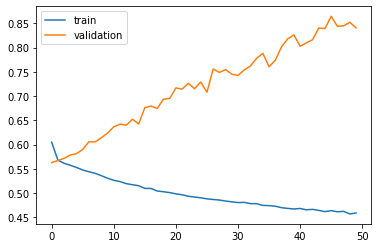

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 0
Best val loss: 0.5626391256650289
#################################
Time to train MLP:  167.154944896698
Entire process took:  167.23908758163452
(10096, 2)


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 16
b_size = 64
dropout_rate_1 = 0.010404898976033083
dropout_rate_2 = 0.23157443486367296

exp_record = []

for f in range(1):#10
        #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_mlp = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = setup_model(n_units, 
                             dropout_rate_1, 
                             dropout_rate_2)
        v_loss, val_weight = fit_model(model, 
                                       train_x_mlp, 
                                       train_y_mlp, 
                                       b_size) 
        print("#################################")
        print("Number of units:", n_units)
        print("Batch size:", b_size)
        print("Dropout rate 1:", dropout_rate_1)
        print("Dropout rate 2:", dropout_rate_2)
        print("Fold:", f)
        print("Best val loss:", v_loss)
        exp_record.append([n_units, b_size, 
                           dropout_rate_1, 
                           dropout_rate_2, 
                            f, v_loss])
        print("#################################")
        if(f==4):
            print(exp_record)
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)
print(yhat_test.shape)

In [11]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NO_EVENT', 'EVENT']
y_test_df.columns = ['NO_EVENT', 'EVENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/EVENT_MLP_Sample_Weight_yhat.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/PDC_y_MLP.feather")

(10096, 2)
